In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint, proportions_ztest

## 1. Обработка и разведочный анализ данных

In [2]:
# Чтение файла с реестром займов в датафрейм
df = pd.read_csv('../data/loans.csv', sep=';')
df.columns = list(map(str.lower, df.columns.values))

# Изменение типа данных столбца TREAT_DATE с object на datetime
df['treat_date'] = pd.to_datetime(df['treat_date'], dayfirst=True)
df.head()

,demand,treat_date,treatment_flag
0,36026098,2023-10-25,1
1,36073351,2023-10-25,1
2,37540360,2023-10-25,1
3,37540643,2023-10-25,0
4,37621229,2023-10-25,0


In [3]:
# Проверка наличия дубликатов:

print('Кол-во дубликатов по полю demand:',\
    len(df[df.duplicated(['demand'])]), '- id займа не уникальны, так как взаимодействия осуществлялись в разные дни.')

print('Кол-во дубликатов по полям demand, treat_date:',\
    len(df[df.duplicated(['demand', 'treat_date'])])) 

Кол-во дубликатов по полю demand: 23734 - id займа не уникальны, так как взаимодействия осуществлялись в разные дни.
Кол-во дубликатов по полям demand, treat_date: 0


In [4]:
# Определение дат взаимодействия:
df['treat_date'].value_counts().sort_values() # взаимодействия осуществлялись 25 октября и 30 октября 2023 года

treat_date
2023-10-25    30105
2023-10-30    31924
Name: count, dtype: int64

#### <span style="color:rgb(100, 24, 63);">Таким образом, мы видим, что A/B-тест проводился в течение двух дней - 25 октября и 30 октября 2023 года. В тесте от 25 октября участвовало 30105 займов, а в тесте от 30 октября - 31924 займа.</span>   
#### _Определим, есть ли займы, участвовавшие в A/B-тесте в оба дня._

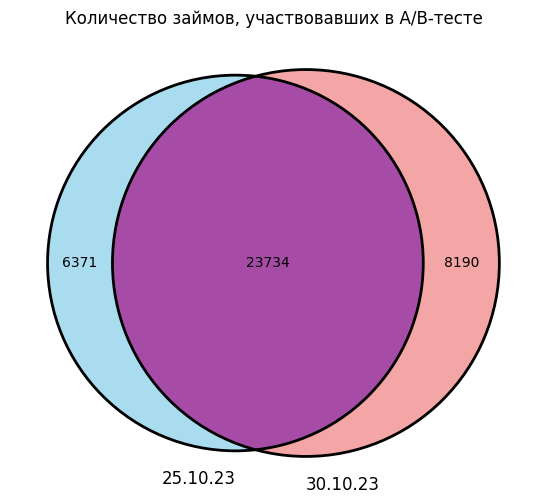

In [5]:
set25 = set(df[df['treat_date'] == '2023-10-25'].demand)
set30 = set(df[df['treat_date'] == '2023-10-30'].demand)

plt.figure(figsize=(8, 6))

venn = venn2(
    [set25, set30], 
    set_labels=('25.10.23', '30.10.23'),
    set_colors=('skyblue', 'lightcoral'),
    alpha=0.7
)

venn.get_patch_by_id('11').set_color('purple')
venn.get_patch_by_id('11').set_alpha(0.7)

venn2_circles(
    [set25, set30], 
    linestyle='-', 
    linewidth=2, 
    color='black'
)

plt.title("Количество займов, участвовавших в A/B-тесте")
plt.grid(False)
plt.show()

#### Как видно из диаграммы выше, бОльшая часть займов участвовала в A/B-тесте в оба дня. Займы, которые участвовали только в одном тесте, составляют 21% и 26% от объема выборок для 25.10 и 30.10 соответственно.   
#### _Определим имеющиеся комбинации флагов взаимодействия 25.10 и 30.10 в структуре займов, участвовавших в тесте два раза. Для этого построим матрицу сопряженности._

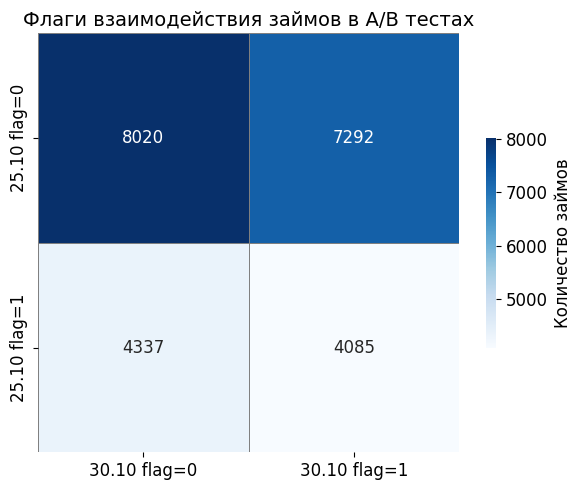

In [6]:
df25 = df[df['treat_date'] == pd.to_datetime('2023-10-25')]
df30 = df[df['treat_date'] == pd.to_datetime('2023-10-30')]

df_intersect = df25.merge(df30, on='demand', how='inner', suffixes=('_2510', '_3010'))
df_conti = df_intersect[['demand', 'treatment_flag_2510', 'treatment_flag_3010']]

contingency_table = pd.crosstab(
    df_conti['treatment_flag_2510'], 
    df_conti['treatment_flag_3010']
)

contingency_table.index = ['25.10 flag=0', '25.10 flag=1']
contingency_table.columns = ['30.10 flag=0', '30.10 flag=1']

plt.figure(figsize=(6, 5))
heatmap = sns.heatmap(contingency_table, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            cbar_kws={'shrink': 0.5},
            linewidths=0.5,
            linecolor='gray',
            annot_kws={'size': 12})

cbar = heatmap.collections[0].colorbar
cbar.set_label('Количество займов', size=12)
cbar.ax.tick_params(labelsize=12)

heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=12)

plt.title('Флаги взаимодействия займов в A/B тестах', fontsize=14, loc='center')
plt.tight_layout()
plt.show()

#### Как видно из матрицы сопряженности, среди рассматриваемых займов имеются все возможные комбинации. Наиболее многочисленна категория займов, по которым отсутствовало целевое взаимодействие как во время первого дня (25.10), так и во время второго (30.10). Вторая по размеру категория описывает ситуацию, когда взаимодействие по займу не произошло в первом дне, но произошло во втором.  
  
#### <span style="color:rgb(100, 24, 63);">Наибольший интерес для дальнейшего анализа представляют две остальные __категории__:</span>   
#### <span style="color:rgb(100, 24, 63);">1. Целевое взаимодействие было в _первом_ дне теста, но отсутствовало во втором (4337 наблюдений);
#### <span style="color:rgb(100, 24, 63);">2. Целевое взаимодействие было и в _первом_ дне теста, и во _втором_ (4085 наблюдений).</span>   

#### <span style="color:rgb(100, 24, 63);">Несмотря на то, что по условию бизнес-логики платежи учитываются в течение 3 дней после взаимодействия, а между первым и вторым днем теста разница 5 дней, включение данных категорий в оценку результата A/B-теста может __исказить__ ее результат, так как факт свершившегося целевого взаимодействия 25 откября мог __оказать влияние__ на поведение заемщика 30 октября. Поэтому из выборки займов от 30 октября целесообразно __исключить__ займы, относящиеся к данным группам для получения более точных выводов.</span>


In [7]:
# Исключаем две категории займов из перечня займов, участвовавших во втором тесте

exclude1_0 = df_intersect[
    (df_intersect['treatment_flag_2510'] == 1) &
    (df_intersect['treatment_flag_3010'] == 0)
    ]['demand'].to_list()

exclude1_1 = df_intersect[
    (df_intersect['treatment_flag_2510'] == 1) &
    (df_intersect['treatment_flag_3010'] == 1)
    ]['demand'].to_list()


df30 = df30[(~df30['demand'].isin(exclude1_0)) & (~df30['demand'].isin(exclude1_1))]

# Промежуточный датафрейм со всеми займами
df = pd.concat([df25, df30], axis=0, ignore_index=True)

In [8]:
# Чтение файла со сведениями о платежах в датафрейм
df2 = pd.read_csv('../data/payments.csv', sep=';')
df2.columns = list(map(str.lower, df2.columns.values))

# Изменение типа данных столбца PAY_STAMP с object на datetime
df2['pay_stamp'] = pd.to_datetime(df2['pay_stamp'], dayfirst=True)
df2.head()

,payment_id,pay_stamp,demand
0,13987558,2023-10-18 17:12:00,35072400
1,14017760,2023-10-20 09:02:00,36764746
2,14025848,2023-10-20 19:07:00,37389598
3,14034783,2023-10-21 19:03:00,37712341
4,14086482,2023-10-25 07:03:00,37549942


In [9]:
# Проверка наличия дубликатов:

print('Кол-во дубликатов по полю payment_id:',\
      len(df2[df2.duplicated(['payment_id'])]), '- id платежей уникальны.')

print('Кол-во дубликатов по полю demand:',\
      len(df2[df2.duplicated(['demand'])]), '- по одному займу может быть несколько разных платежей.')

Кол-во дубликатов по полю payment_id: 0 - id платежей уникальны.
Кол-во дубликатов по полю demand: 1287 - по одному займу может быть несколько разных платежей.


In [10]:
# JOIN-им платежи к данным о займах:

total_df = df.merge(df2, on='demand', how='left')
total_df['payment_id'] = total_df['payment_id'].astype('Int64')
total_df.sample(15)

,demand,treat_date,treatment_flag,payment_id,pay_stamp
13406,37303409,2023-10-25,1,<NA>,NaT
24716,37063377,2023-10-25,1,<NA>,NaT
35555,37726113,2023-10-30,0,<NA>,NaT
29697,36430538,2023-10-25,1,<NA>,NaT
52115,37193755,2023-10-30,1,<NA>,NaT
46338,37198987,2023-10-30,0,<NA>,NaT
24449,37791532,2023-10-25,1,<NA>,NaT
30419,37033069,2023-10-25,1,<NA>,NaT
34122,37866995,2023-10-30,0,<NA>,NaT
10707,37765805,2023-10-25,1,<NA>,NaT


In [11]:
# Разделение датафрейма на 2 для дальнейшей обработки:

df_nan = total_df[total_df['payment_id'].isna()].copy() # датафрейм с займами, по которым платежи не поступали
df_pay = total_df[~total_df['payment_id'].isna()].copy() # датафрейм с займами, по которым платежи поступали

In [12]:
# # Нахождение разности дней между датой платежа и датой взаимодействия:

df_pay['delta_days'] = (df_pay['pay_stamp'] - df_pay['treat_date']).dt.days
df_pay.sample(10)

,demand,treat_date,treatment_flag,payment_id,pay_stamp,delta_days
31284,35217248,2023-10-30,1,14037116,2023-10-22 03:55:00,-8
32130,37805098,2023-10-30,1,14152814,2023-10-28 20:25:00,-2
52187,36585118,2023-10-30,0,14101515,2023-10-25 17:52:00,-5
40258,37481220,2023-10-30,0,14106471,2023-10-25 23:38:00,-5
30370,37055160,2023-10-25,1,14252111,2023-11-03 12:56:00,9
16791,37173004,2023-10-25,1,14094311,2023-10-25 08:48:00,0
11472,35757668,2023-10-25,0,14175590,2023-10-30 11:38:00,5
16589,37367886,2023-10-25,0,14231893,2023-11-02 15:21:00,8
26574,37625101,2023-10-25,1,14105546,2023-10-25 22:03:00,0
2474,35869903,2023-10-25,1,14262143,2023-11-03 23:22:00,9


In [13]:
# Фильтрация датафрейма согласно условию, что платежи учитываются в течение 3 дней после взаимодействия:

pd.DataFrame(df_pay[df_pay['delta_days'].isin(range(4))].delta_days.value_counts())

,count
delta_days,
0,1199
1,905
2,689
3,489


#### Таким образом, по займам, по которым поступал хотя бы один платёж, больше всего платежей поступало в день взаимодействия

#### _Разобьем займы с оплатами на две группы:_  
#### 1. _Те, для которых выполняется условие 3-дневного закрепления;_
#### 2. _Те, для которых оно нарушается (платеж поступил до взаимодействия или позднее, чем через 3 дня после взаимодействия)._  
#### _Вторую категорию отнесем к займам без оплаты_

In [14]:
# Среди займов с оплатами выделим те, для которых выполняется и нарушается условие 3-дневного закрепления
paid_3_days = df_pay[(df_pay['delta_days'] >= 0) & (df_pay['delta_days'] <= 3)].copy()

not_paid_3_days = df_pay[(df_pay['delta_days'] < 0) | (df_pay['delta_days'] > 3)].copy()
not_paid_3_days.drop(columns='delta_days', inplace=True)

In [15]:
# Агрегация датафрейма not_paid_3_days по количеству платежей для каждого займа:

not_paid_3_days_agg = not_paid_3_days.pivot_table(index=['demand', 'treat_date'], values='treatment_flag')
not_paid_3_days_agg.reset_index(drop=False , inplace=True)

df_nan = pd.concat([df_nan, not_paid_3_days_agg], axis=0, ignore_index=True)

# Создание столбца с количеством поступивших платежей:
df_nan['payments_amount'] = 0
df_nan.drop(columns=['payment_id', 'pay_stamp'], inplace=True)
df_nan

,demand,treat_date,treatment_flag,payments_amount
0,36026098,2023-10-25,1.0,0
1,36073351,2023-10-25,1.0,0
2,37540360,2023-10-25,1.0,0
3,37540643,2023-10-25,0.0,0
4,37621229,2023-10-25,0.0,0
...,...,...,...,...
50965,38287369,2023-10-30,1.0,0
50966,38302835,2023-10-30,1.0,0
50967,38313120,2023-10-30,0.0,0
50968,38314234,2023-10-30,0.0,0


In [16]:
# Агрегация датафрейма df_pay по количеству платежей для каждого займа:

df_pay_agg = paid_3_days.pivot_table(index=['demand', 'treat_date'],
                                values=['treatment_flag', 'delta_days'],
                                aggfunc={'treatment_flag': 'mean', 'delta_days': len})

df_pay_agg.reset_index(drop=False , inplace=True)
df_pay_agg.rename(columns={'delta_days': 'payments_amount'}, inplace=True)
df_pay_agg

,demand,treat_date,payments_amount,treatment_flag
0,33875999,2023-10-25,1,1.0
1,33986987,2023-10-25,3,0.0
2,34256627,2023-10-25,1,1.0
3,34261435,2023-10-25,1,1.0
4,34294035,2023-10-30,1,1.0
...,...,...,...,...
2998,38297752,2023-10-30,2,1.0
2999,38303354,2023-10-30,2,1.0
3000,38305513,2023-10-30,1,1.0
3001,38314493,2023-10-30,1,1.0


In [17]:
# Объединение обработанных датафреймов в единый итоговый датафрейм:

df_itog = pd.concat([df_pay_agg, df_nan], axis=0, ignore_index=True)
df_itog['payment_flag'] = (df_itog['payments_amount'] > 0).astype('int')
df_itog.head()

,demand,treat_date,payments_amount,treatment_flag,payment_flag
0,33875999,2023-10-25,1,1.0,1
1,33986987,2023-10-25,3,0.0,1
2,34256627,2023-10-25,1,1.0,1
3,34261435,2023-10-25,1,1.0,1
4,34294035,2023-10-30,1,1.0,1


## 2. Расчет описательных статистик и проведение статистических тестов

#### _Определим количество наблюдений (займов), среднее количество платежей на займ и долю займов с оплатой в разбивке по группам и датам:_

In [18]:
df_itog.groupby(['treatment_flag']).agg(
    n_obs = ('payments_amount', 'count'),
    avg_pays_count = ('payments_amount', 'mean'),
    pays_share = ('payment_flag', 'mean'))

,n_obs,avg_pays_count,pays_share
treatment_flag,,,
0.0,31723,0.058191,0.053557
1.0,22250,0.064539,0.058607


In [19]:
df_itog.groupby(['treatment_flag', 'treat_date']).agg(
    n_obs = ('payments_amount', 'count'),
    avg_pays_count = ('payments_amount', 'mean'),
    pays_share = ('payment_flag', 'mean'))

n_obs  avg_pays_count  pays_share
treatment_flag treat_date                                   
0.0            2023-10-25  19424        0.063118    0.057764
               2023-10-30  12299        0.050411    0.046914
1.0            2023-10-25  10926        0.070474    0.063884
               2023-10-30  11324        0.058813    0.053515

#### _Рассмотрим распределения количества платежей:_

In [20]:
pays_amount = df_itog.pivot_table(
    index=['payments_amount'],
    columns=['treat_date', 'treatment_flag'],
    values=['demand'],
    aggfunc=len
)

pays_amount = pays_amount.rename(columns={'demand': 'Кол-во займов'}, level=0)
pays_amount = pays_amount.astype('Int64')
pays_amount

Кол-во займов                         
treat_date         2023-10-25        2023-10-30       
treatment_flag            0.0    1.0        0.0    1.0
payments_amount                                       
0                       18302  10228      11722  10718
1                        1049    641        546    562
2                          52     48         24     33
3                          12      3          2      6
4                           8      6          5      5
5                           1   <NA>       <NA>   <NA>

#### Таким образом, в контрольной группе имеется 31,7 тыс. наблюдений, а в тестовой - 22,2 тыс. наблюдений.    
#### Среднее количество платежей и в контрольной, и в тестовой группе оказалось близко к нулю. Это говорит о том, что во всех группах по большинству займов в течение 3-х дней платежей не поступало.

#### _Рассмотрим доли оплаченных и неоплаченных займов по группам:_

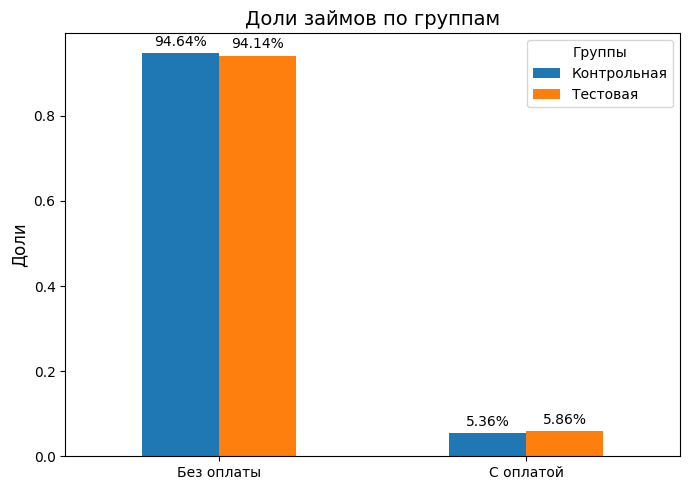

In [21]:
control_data = df_itog[df_itog['treatment_flag'] == 0].payment_flag
test_data = df_itog[df_itog['treatment_flag'] == 1].payment_flag

data_to_plot = pd.DataFrame({
    'Контрольная': [1 - control_data.mean(), control_data.mean()],
    'Тестовая': [1 - test_data.mean(), test_data.mean()]
}, index=['Без оплаты', 'С оплатой'])

fig, ax = plt.subplots(figsize=(7, 5))
bars = data_to_plot.plot(kind='bar', ax=ax)

for container in ax.containers:
    ax.bar_label(container, 
                 labels=[f'{val:.2%}' for val in container.datavalues],
                 padding=3,
                 fontsize=10)

plt.title('Доли займов по группам', fontsize=14)
plt.ylabel('Доли', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Группы')
plt.tight_layout()
plt.show()

#### _Рассмотрим долю займов с оплатой в разбивке по датам взаимодействия:_

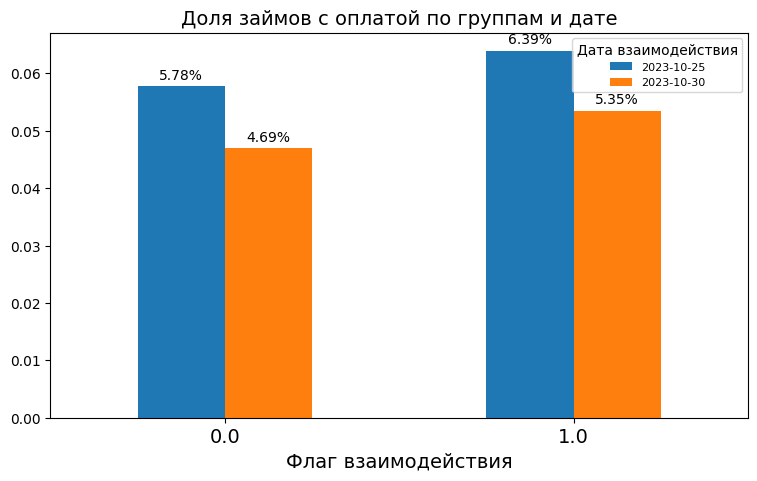

In [22]:
grouped_df = df_itog.groupby(['treatment_flag', 'treat_date'])['payment_flag'].mean().unstack()
grouped_df.columns = [col.strftime('%Y-%m-%d') for col in grouped_df.columns]

ax = grouped_df.plot(kind='bar', figsize=(9, 5))

for container in ax.containers:
    ax.bar_label(container, labels=[f'{x:.2%}' for x in container.datavalues], 
                 padding=3, fontsize=10)

ax.set_xlabel('Флаг взаимодействия', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=14)
ax.set_title('Доля займов с оплатой по группам и дате', fontsize=14)
ax.legend(title='Дата взаимодействия', loc='upper right', fontsize=8)
plt.show()

#### Таким образом, показатель доли займов с оплатой выше в тестовой группе - 5.9% против 5.4% в контрольной группе.

#### <span style="color:rgb(100, 24, 63);">Как видно из расчета среднего количества платежей, данная метрика не является информативной, так по абсолютному большинству займов как в контрольной, так и в тестовой группе, платежей после взаимодействия не поступало. Поэтому выборки для анализа сформируем из категориального __бинарного__ признака - __флага платежа__, а в качестве ключевых метрик возьмем __выборочные доли "успехов"__ (займов, по которым поступил платеж) для контрольной и тестовой группы соответственно.</span> 
 
#### <span style="color:rgb(100, 24, 63);">Основным методом анализа в такой ситуации (большой объем выборки, когда биномиальное распределение приближается к нормальному) является __Z-test для двух пропорций__, проверяющий гипотезу о том, является ли статистически значимым различие в двух долях. Так как доля займов с платежом в тестовой группе оказалась несколько больше, чем в контрольной, есть основание предполагать, что запущенная в A/B-тесте фича привнесла __положительный__ эффект, поэтому проведем Z-тест с правосторонней альтернативой.</span>

#### _1. Вычислим выборочные доли как точечные несмещенные оценки "успеха" в биномиальном распределении, а также определим для них 95%-е доверительные интервалы_

In [23]:
data = [
    {'count': control_data.sum(), 'nobs': control_data.count(), 'p_hat': control_data.mean(), 'name': 'Контрольная группа'},
    {'count': test_data.sum(), 'nobs': test_data.count(), 'p_hat': test_data.mean(), 'name': 'Тестовая группа'}
]

for dat in data:
    lower, upper = proportion_confint(count=dat['count'], nobs=dat['nobs'], alpha=0.05, method='normal')
    print(f'{dat['name']}: точечная оценка: {dat['p_hat']:.5f}, 95%-й доверительный интервал: [{lower:.5f}; {upper:.5f}].')

Контрольная группа: точечная оценка: 0.05356, 95%-й доверительный интервал: [0.05108; 0.05603].
Тестовая группа: точечная оценка: 0.05861, 95%-й доверительный интервал: [0.05552; 0.06169].


#### Из полученных расчетов видно, что доверительный интервал для выборочной доли из тестовой группы имеет совсем небольшое пересечение слева с интервалом для выборочной доли из контрольной группы.

#### _2. Проверим гипотезу о равенстве пропорций. Альтернативная гипотеза будет заключаться в том, что значение выборочной доли для тестовой группы будет статистически значимо превышать значение доли для контрольной группы. Таким образом, проведем Z-test с правосторонней альтернативой._

In [24]:
z_stat, p_value = proportions_ztest(
    count=[test_data.sum(), control_data.sum()],
    nobs=[test_data.count(), control_data.count()],
    alternative='larger'
)

z_stat, p_value

(np.float64(2.519091695853578), np.float64(0.00588290057710272))

#### Таким образом, нулевая гипотеза о равенстве долей отвергается, различие между долями в контрольной и тестовой группах не случайно (доля в тестовой группе выше, чем в контрольной).  
* Абсолютный прирост конверсии: +0.51 п.п.  
* Относительный прирост (lift): +9,4% 
#### Убедимся в том, что в наших выборках нет "проблем" и тест для них вообще можно применять. Для этого проведем A/A и B/B тесты на исходных выборках, а также с помощью метода Монте-Карло, многократно (1000 раз) семплируя выборки и проводя z-тест на равенство пропорций. 

In [25]:
# A/A и B/B тесты на исходных выборках
 
for sample in data:
    _, p_value = proportions_ztest(
        count=[sample['count'], sample['count']],
        nobs=[sample['nobs'], sample['nobs']],
        alternative='larger'
    )

    print(f'{sample['name']}: p_value = {p_value:.3f}')

Контрольная группа: p_value = 0.500
Тестовая группа: p_value = 0.500


#### Как для А/А, так и для B/B теста p-value > 0.05, гипотезы о равенстве долей уверенно не отвергаются при данном уровне значимости. Для большей уверенности в том, что наш критерий отличает одну и ту же группу от самой себя не лучше, чем случайное угадывание, проведем имитации Монте-Карло.

In [26]:
# Метод Монте-Карло
N = 1000

pvalues = []
for smpl in [control_data, test_data]:
    for _ in range(N):
        smpl1 = smpl.sample(len(smpl), replace=True)
        smpl2 = smpl.sample(len(smpl), replace=True)
        res = proportions_ztest(
            count=[smpl1.sum(), smpl2.sum()],
            nobs=[smpl1.count(), smpl2.count()],
            alternative='larger'
        )
        pvalues.append(res[1])

pvalues_aa, pvalues_bb = pvalues[: N], pvalues[N: ]

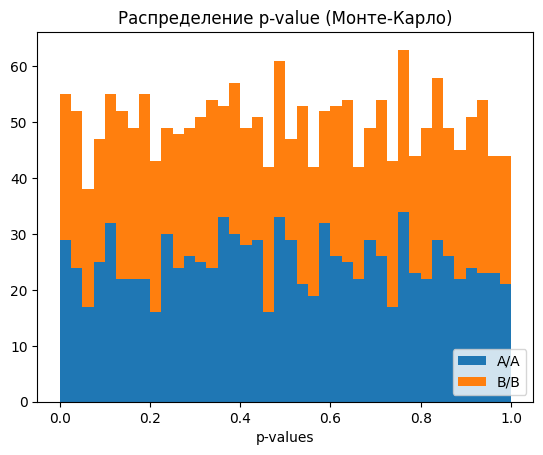

In [27]:
plt.hist([pvalues_aa, pvalues_bb], stacked=True, bins=40, label=['A/A', 'B/B'])
plt.xlabel('p-values')
plt.title('Распределение p-value (Монте-Карло)', fontsize=12)
plt.legend(loc='lower right')
plt.show()

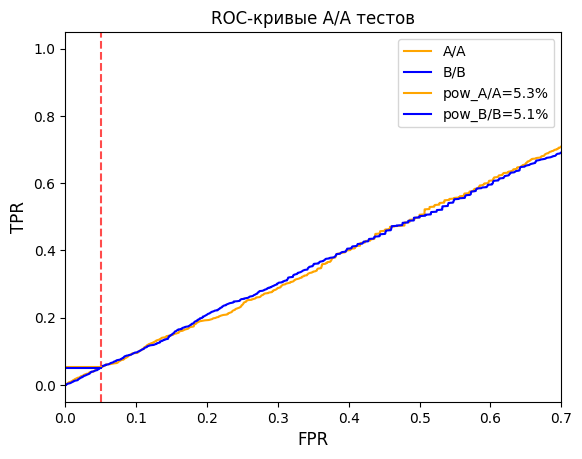

In [28]:
alpha = 0.05
power_aa = np.mean(np.array(pvalues_aa) < alpha)
power_bb = np.mean(np.array(pvalues_bb) < alpha)

fig, ax = plt.subplots()

ax.plot(np.sort(pvalues_aa), [i / N for i in range(N)], color='orange', label='A/A')
ax.plot(np.sort(pvalues_bb), [i / N for i in range(N)], color='blue', label='B/B')
ax.axvline(x=alpha, color='r', linestyle='--', alpha=0.7)
ax.plot([0, alpha], [power_aa, power_aa], color='orange', label=f'pow_A/A={power_aa * 100:.1f}%')
ax.plot([0, alpha], [power_bb, power_bb], color='blue', label=f'pow_B/B={power_bb * 100:.1f}%')

plt.xlim(0, 0.7)
plt.xlabel('FPR', fontsize=12)
plt.ylabel('TPR', fontsize=12)
plt.title(f'ROC-кривые A/A тестов', fontsize=12)
plt.legend()
plt.show()

#### Как видно из полученных гистограмм распределения и ROC-кривых, для обоих тестов распределение p-value походит на равномерное. Это означает, что вероятности получения того или иного p-value в тестах примерно одинаковые. Следовательно, вероятность получения ложноположительного результата при отстутствии реальных различий возникает только по случайности с заданной вероятностью alpha = 0.05. Таким образом, можно сделать вывод о том, что система сплитования работает корректно, а критерий значимости откалиброван верно.

#### Проведем теперь пост-оценку мощности теста, чтобы определить, как часто мы будем верно отвергать нулевую гипотезу. Для этого также проведем эксперимент методом Монте-Карло, многократно семплируя выборки и проводя z-test на равенство пропорций.

In [29]:
# Метод Монте-Карло

pvalues = []
for _ in range(N):
    test = test_data.sample(len(test_data), replace=True)
    control = control_data.sample(len(control_data), replace=True)
    res = proportions_ztest(
        count=[test.sum(), control.sum()],
        nobs=[test.count(), control.count()],
        alternative='larger'
    )
    pvalues.append(res[1])

#### Построим гистограмму распределения полученных в результате эксперимента p-value.

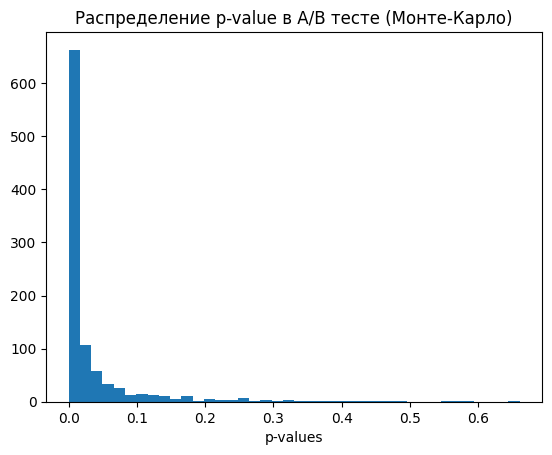

In [30]:
plt.hist(pvalues, bins=40)
plt.xlabel('p-values')
plt.title('Распределение p-value в A/B тесте (Монте-Карло)', fontsize=12)
plt.show()

#### Как видно из построенной гистограммы, p-value отлично от равномерного, основная масса наблюдений сконцентрирована возле нуля, т.е. в бОльшей части проведенных экспериментов полученные p-value оказались ниже порога значимости, что говорит о достаточно высокой мощности теста. Вычислим непосредственно мощность и построим ROC-кривую.

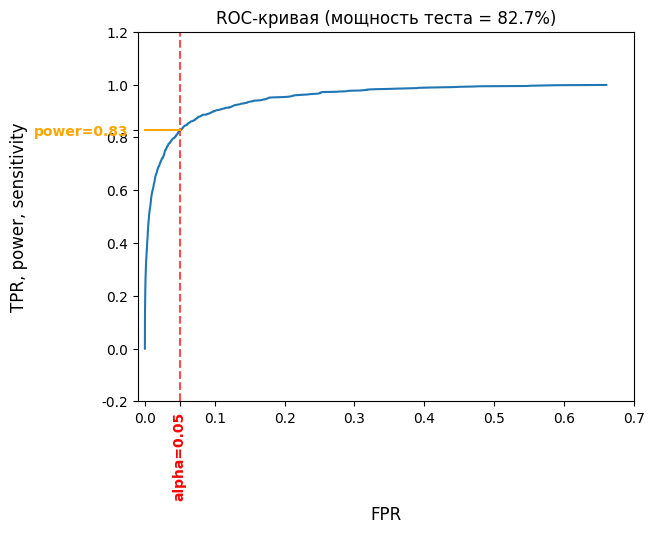

In [31]:
alpha = 0.05
power = np.mean(np.array(pvalues) < alpha)

fig, ax = plt.subplots()

ax.plot(np.sort(pvalues), [i / N for i in range(N)])
ax.axvline(x=alpha, color='r', linestyle='--', alpha=0.7)
ax.plot([0, alpha], [power, power], color='orange')

current_xticks = list(ax.get_xticks())
current_xlabels = [str(round(tick, 1)) for tick in ax.get_xticks()]

if alpha not in current_xticks:
    current_xticks.append(alpha)
    current_xlabels.append(f'alpha={alpha:.2f}')
    ax.set_xticks(current_xticks)
    ax.set_xticklabels(current_xlabels)

for label in ax.get_xticklabels():
    if label.get_text() == f'alpha={alpha:.2f}':
        label.set_color('red')
        label.set_fontweight('bold')
        label.set_rotation(90)

current_yticks = list(ax.get_yticks())
current_ylabels = [str(round(tick, 1)) for tick in ax.get_yticks()]

if power not in current_yticks:
    current_yticks.append(power)
    current_ylabels.append(f'power={power:.2f}')
    ax.set_yticks(current_yticks)
    ax.set_yticklabels(current_ylabels)

for label in ax.get_yticklabels():
    if label.get_text() == f'power={power:.2f}':
        label.set_color('orange')
        label.set_fontweight('bold')

plt.xlim(-0.01, 0.7)
plt.xlabel('FPR', fontsize=12)
plt.ylabel('TPR, power, sensitivity', fontsize=12)
plt.title(f'ROC-кривая (мощность теста = {(power * 100):.1f}%)', fontsize=12)
plt.show()

#### Полученная ROC-кривая имеет выпуклую форму, а мощность теста составила 83%, что говорит о достаточной чувствительности проведенного A/B-теста.

#### __Основные выводы:__
1. На основании проведенного z-теста на равенство пропорций с правосторонней альтернативной гипотезой мы отвергаем нулевую гипотезу об отсутствии положительного эффекта. Разница в долях между тестовой и контрольной группами является статистически значимой (p-value ≈ 0.006 при уровне значимости alpha = 0.05). Это указывает на наличие положительного эффекта от внедренного изменения.

2. Величина наблюдаемого эффекта в абсолютном приросте конверсии составила +0.51 п.п., а в относительном приросте (lift) +9,4%, что можно считать значимым с точки зрения бизнеса. При средней сумме платежей, поступившей в течение 3-х дней после взаимодействия, равной 5000 руб. и стоимости отправки смс-сообщения в 3 руб. чистый финансовый эффект от внедрения данной фичи на контрольной группе был бы равен:  
__Чистый финансовый эффект__ = 31 723 (база должников из контрольной группы) * (0.0051 * 5000 - 3) = __713 767,5 руб.__

3. Для оценки применимости теста на имеющихся данных были проведены A/A и B/B тесты методом Монте-Карло, по результатам которых было получено подтверждение корректности системы сплитования и подобранного критерия. Вероятность ложноположительного результата контролируется уровнем значимости alpha. 

4. Для оценки надежности полученного значимого результата была проведена пост-оценка мощности теста методом Монте-Карло, исходя из наблюдаемых пропорций и размеров выборок. Расчетная мощность составила 83%. Это означает, что при условии, что наблюдаемый эффект (разница в долях) соответствует реальному, данный тестовый дизайн (с текущими объемами выборок и уровнем вариативности) позволил бы корректно обнаружить эффект в 81% случаев повторения эксперимента.

#### <span style="color:rgb(100, 24, 63);">__Итоговая интерпретация:__</span>
<span style="color:rgb(100, 24, 63);">Уровень мощности в 83% превышает общепринятый порог в 80%, что свидетельствует о достаточной чувствительности проведенного A/B-теста. Полученный статистически значимый результат (p-value < 0.05) является надежным: вероятность ложноположительного заключения контролируется уровнем alpha (5%), а вероятность не обнаружить реальный эффект (ошибка II рода) в подобных условиях оценивается примерно в 17%.</span>

<span style="color:rgb(100, 24, 63);">Таким образом, на основании данных можно сделать обоснованный вывод в пользу наличия положительного эффекта от тестируемого изменения.</span>